In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import scipy.cluster
import shap

In [2]:
deposit_data = pd.read_csv("../../Curated_data/final_dataset.csv", low_memory=False)


In [3]:
deposit_data.iloc[: ,:20]

,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total,phi_0,phi_1,phi_2,phi_3,phi_4,phi_5,phi_6,phi_7,phi_8,phi_9
0,KV-NME001,0.437814,0.509816,0.461455,0.400922,0.8800,0.127305,0.250,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,KV-NME001,0.438061,0.509789,0.460591,0.410138,0.8800,0.160479,0.250,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,KV-NME001,0.448174,0.508800,0.426068,0.442396,0.9900,0.128743,0.250,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,KV-NME001,0.448431,0.508777,0.425204,0.442396,0.9900,0.141317,0.375,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,KV-NME001,0.448683,0.508755,0.424340,0.442396,0.9900,0.153293,0.500,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,KV365,0.629186,0.001755,0.432766,0.543779,0.9235,0.078443,0.050,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000246,0.003618,0.000032
2614,KV365,0.629096,0.001314,0.431988,0.539171,0.9235,0.074850,0.050,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000262,0.003631,0.000029
2615,KV365,0.629011,0.000877,0.431205,0.543779,0.8584,0.076647,0.050,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000279,0.003641,0.000027
2616,KV365,0.628921,0.000436,0.430427,0.525346,0.8584,0.077246,0.050,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000297,0.003651,0.000025


In [4]:
deposit_data['Random_Values'] = np.random.rand(len(deposit_data))

In [7]:
# Assuming deposit_data is your DataFrame
# Extract the names of the first 98 columns
phi_columns = deposit_data.columns[10:-1].tolist()

# Display the list of column names
print(phi_columns[-1])


phi_6402


In [8]:
deposit_data = deposit_data.dropna(subset=['Density_gcm3'] + covariates + phi_columns)

In [ ]:
total_columns = ['CP_Total','PO_Total', 'PY_Total']

#all covariates
covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm', 'Random_Values'] 

In [9]:
p = len(phi_columns) + len(covariates)

# Deepkriging train test split

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

phi_columns = deposit_data.columns[10:-1].tolist()

torch.manual_seed(42)
np.random.seed(42)

p = len(phi_columns) + len(covariates)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(deposit_data[phi_columns + covariates],
                                                    deposit_data['Density_gcm3'],
                                                    test_size=0.2, random_state=42)

# Define the neural network
model = nn.Sequential(
    nn.Linear(in_features=p, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=1))

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

# Training loop
for step in range(601):
    pre = model(torch.tensor(X_train.values, dtype=torch.float32))
    mse = mse_loss(pre, torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32))
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()


torch.manual_seed(42)
np.random.seed(42)
# Store metrics for this fold
test_predictions = model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()

# Print metrics for the test set
print_metrics(y_test.values, test_predictions, "Test")



NameError: name 'print_metrics' is not defined

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
# Store metrics for this fold
test_predictions = model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()

# Print metrics for the test set
print_metrics(y_test.values, test_predictions, "Test")


Metrics for Test set:
  MSE: 0.0030
  RMSE: 0.0548
  MAE: 0.0378
  R^2: 0.7940



In [ ]:
X_test

,phi_0,phi_1,phi_2,phi_3,phi_4,phi_5,phi_6,phi_7,phi_8,phi_9,...,phi_6399,phi_6400,phi_6401,phi_6402,CP_Total,PO_Total,PY_Total,RQD_Pct,Cr_ppm,Random_Values
2240,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.050,0.020000,0.00,0.9930,0.144910,0.794578
175,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.250,0.133333,0.00,0.9900,0.245509,0.174366
1253,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.925,0.000000,0.00,0.9804,0.109581,0.125186
1461,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.025,0.020000,0.00,0.9698,0.076048,0.651233
2430,0.0,0.0,0.0,0.0,0.000027,0.000015,0.0,0.000137,0.038257,0.031329,...,0.0,0.0,0.0,0.0,0.000,0.013333,0.08,0.9351,0.904192,0.602943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.125,0.133333,0.00,0.7801,0.476707,0.465206
482,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.500,0.200000,0.00,0.9800,0.156886,0.454541
1032,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.275,0.140000,0.00,0.9180,0.503593,0.230009
438,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.045,0.030667,0.00,0.7375,0.443593,0.706242


# Combinations for the phi feature

In [ ]:
import pandas as pd
from itertools import combinations
X_phi_c = X_test.iloc[:, 6403:]
X_easy = X_phi_c
X_phi = X_test.iloc[:, :6403]

# Assuming X_easy is your existing DataFrame and X_phi is another DataFrame
# Create all possible combinations of columns and generate a new DataFrame for each combination
permutations_phi = []
Q = []
#covariates + phi - active variable
size = len(covariates)-1+1
Q.append(size)

permutations_phi.append(pd.concat([X_easy.copy(), X_phi], axis=1))

for r in range(1, len(X_easy.columns) + 1):
    for combo in combinations(X_easy.columns, r):
        new_df = X_easy.copy()
        new_df[list(combo)] = 0
        permutations_phi.append(pd.concat([new_df, X_phi], axis=1))




permutations_phi_0 = []

# Create a DataFrame with all columns in X_phi set to 0
zero_X_phi = pd.DataFrame(0, index=X_phi.index, columns=X_phi.columns)

permutations_phi_0.append(pd.concat([X_easy.copy(), zero_X_phi], axis=1))


for r in range(1, len(X_easy.columns) + 1):
    for combo in combinations(X_easy.columns, r):
        new_df = X_easy.copy()
        new_df[list(combo)] = 0
        permutations_phi_0.append(pd.concat([new_df, zero_X_phi], axis=1))
        n_features = len(X_CP_Total_c.columns[-4:]) + 1 - len(combo)
        Q.append(n_features)



permutations_phi = [df[X_test.columns] for df in permutations_phi]
permutations_phi_0 = [df[X_test.columns] for df in permutations_phi_0]

Q_phi = Q

In [ ]:
X_phi_c

,CP_Total,PO_Total,PY_Total,RQD_Pct,Cr_ppm,Random_Values
2240,0.050,0.020000,0.00,0.9930,0.144910,0.794578
175,0.250,0.133333,0.00,0.9900,0.245509,0.174366
1253,0.925,0.000000,0.00,0.9804,0.109581,0.125186
1461,0.025,0.020000,0.00,0.9698,0.076048,0.651233
2430,0.000,0.013333,0.08,0.9351,0.904192,0.602943
...,...,...,...,...,...,...
1620,0.125,0.133333,0.00,0.7801,0.476707,0.465206
482,0.500,0.200000,0.00,0.9800,0.156886,0.454541
1032,0.275,0.140000,0.00,0.9180,0.503593,0.230009
438,0.045,0.030667,0.00,0.7375,0.443593,0.706242


# Combinations for the rest of the features

In [ ]:
import pandas as pd
from itertools import combinations

X_CP_Total = X_test[['CP_Total']]
selected_columns = [col for col in X_test.columns if col != 'CP_Total']
X_CP_Total_c = X_test[selected_columns]

# Assuming X_CP_Total_c is your existing DataFrame and X_CP_Total is another DataFrame
# Create all possible combinations of columns and generate a new DataFrame for each combination
new_dataframes_CP_Total = []
Q = []
new_dataframes_CP_Total.append(pd.concat([X_CP_Total_c.copy(), X_CP_Total], axis=1))

numcovar = len(covariates)-1
#covariates + phi - active variable
size = len(covariates)-1+1
Q.append(size)

for r in range(1, len(X_CP_Total_c.columns[-numcovar:]) + 1):
    for combo in combinations(X_CP_Total_c.columns[-numcovar:], r):
        new_df = X_CP_Total_c.copy()
        new_df[list(combo)] = 0
        new_dataframes_CP_Total.append(pd.concat([new_df, X_CP_Total], axis=1))
        # 4 features + phi feature - the number of features being 0 is the number of active features 


for idx in range(len(new_dataframes_CP_Total)):
    new_df = new_dataframes_CP_Total[idx].copy()
    for col in new_df.columns[:6403]:
        new_df[col].values[:] = 0
    new_dataframes_CP_Total.append(new_df)



# Subtract one from each element using list comprehension



new_dataframes_CP_Total_aux = new_dataframes_CP_Total

# Assuming X_CP_Total_c is your existing DataFrame and X_CP_Total is another DataFrame
# Create all possible combinations of columns and generate a new DataFrame for each combination
new_dataframes_CP_Total_0 = []

# Create a DataFrame with all columns in X_CP_Total set to 0
zero_X_CP = pd.DataFrame(0, index=X_CP_Total.index, columns=X_CP_Total.columns)

new_dataframes_CP_Total_0.append(pd.concat([X_CP_Total_c.copy(), zero_X_CP], axis=1))


for r in range(1, len(X_CP_Total_c.columns[-numcovar:]) + 1):
    for combo in combinations(X_CP_Total_c.columns[-numcovar:], r):
        new_df = X_CP_Total_c.copy()
        new_df[list(combo)] = 0
        new_dataframes_CP_Total_0.append(pd.concat([new_df, zero_X_CP], axis=1))
        n_features = len(X_CP_Total_c.columns[-numcovar:]) + 1 - len(combo)
        Q.append(n_features)



for idx in range(len(new_dataframes_CP_Total_0)):
    new_df = new_dataframes_CP_Total_0[idx].copy()
    for col in new_df.columns[:6403]:
        new_df[col].values[:] = 0
    new_dataframes_CP_Total_0.append(new_df)


result_list = [x - 1 for x in Q]
Q = Q + result_list


all_subgroups_CP_Total = new_dataframes_CP_Total + new_dataframes_CP_Total_0
len(all_subgroups_CP_Total)

128

In [ ]:
Q

[6,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 1,
 5,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 0]

In [ ]:
import pandas as pd
from itertools import combinations
def subgroups(column):
    X_column = X_test[[column]]
    selected_columns = [col for col in X_test.columns if col != column]
    X_column_c = X_test[selected_columns]

    new_dataframes_column = []

    new_dataframes_column.append(pd.concat([X_column_c.copy(), X_column], axis=1))

    Q = []
    
    numcovar = len(covariates)-1
    #covariates + phi - active variable
    size = len(covariates)-1+1
    Q.append(size)

    for r in range(1, len(X_column_c.columns[-numcovar:]) + 1):
        for combo in combinations(X_column_c.columns[-numcovar:], r):
            new_df = X_column_c.copy()
            new_df[list(combo)] = 0
            new_dataframes_column.append(pd.concat([new_df, X_column], axis=1))


    for idx in range(len(new_dataframes_column)):
        new_df = new_dataframes_column[idx].copy()
        for col in new_df.columns[:6403]:
            new_df[col].values[:] = 0
        new_dataframes_column.append(new_df)



    new_dataframes_column_0 = []

    # Create a DataFrame with all columns in X_column set to 0
    zero_X_CP = pd.DataFrame(0, index=X_column.index, columns=X_column.columns)

    new_dataframes_column_0.append(pd.concat([X_column_c.copy(), zero_X_CP], axis=1))


    for r in range(1, len(X_column_c.columns[-numcovar:]) + 1):
        for combo in combinations(X_column_c.columns[-numcovar:], r):
            new_df = X_column_c.copy()
            new_df[list(combo)] = 0
            new_dataframes_column_0.append(pd.concat([new_df, zero_X_CP], axis=1))
            n_features = len(X_CP_Total_c.columns[-numcovar:]) + 1 - len(combo)
            Q.append(n_features)

    for idx in range(len(new_dataframes_column_0)):
        new_df = new_dataframes_column_0[idx].copy()
        for col in new_df.columns[:6403]:
            new_df[col].values[:] = 0
        new_dataframes_column_0.append(new_df)

    
    result_list = [x - 1 for x in Q]
    Q = Q + result_list

    sorted_dfs1 = [df[X_test.columns] for df in new_dataframes_column]
    sorted_dfs2 = [df[X_test.columns] for df in new_dataframes_column_0]

    return sorted_dfs1, sorted_dfs2, Q

In [ ]:
for col in X_easy.columns.tolist():
    exec(f"permutations_{col}, permutations_{col}_0, Q_{col} = subgroups('{col}')")

In [ ]:
import math


psi_Random_Values = 0 
S_abs = 7
S_fact = math.factorial(S_abs)
for i in range(len(permutations_Random_Values)):
               Q_c = model(torch.tensor(permutations_Random_Values_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_Random_Values[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_Random_Values[i])*math.factorial(S_abs - Q_Random_Values[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_Random_Values = psi_Random_Values + summand



In [ ]:
psi_CP_Total = 0 
S_abs = 7
S_fact = math.factorial(S_abs)
for i in range(len(permutations_CP_Total)):
               Q_c = model(torch.tensor(permutations_CP_Total_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_CP_Total[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_CP_Total[i])*math.factorial(S_abs - Q_CP_Total[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_CP_Total = psi_CP_Total + summand

In [ ]:
psi_PY_Total = 0 
S_abs = 7
S_fact = math.factorial(S_abs)
for i in range(len(permutations_PY_Total)):
               Q_c = model(torch.tensor(permutations_PY_Total_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_PY_Total[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_PY_Total[i])*math.factorial(S_abs - Q_PY_Total[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_PY_Total = psi_PY_Total + summand

In [ ]:
psi_PO_Total = 0 
S_abs = 7
S_fact = math.factorial(S_abs)
for i in range(len(permutations_PO_Total)):
               Q_c = model(torch.tensor(permutations_PO_Total_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_PO_Total[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_PO_Total[i])*math.factorial(S_abs - Q_PO_Total[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_PO_Total = psi_PO_Total + summand

In [ ]:
psi_RQD_Pct = 0 
S_abs = 7
S_fact = math.factorial(S_abs)
for i in range(len(permutations_RQD_Pct)):
               Q_c = model(torch.tensor(permutations_RQD_Pct_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_RQD_Pct[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_RQD_Pct[i])*math.factorial(S_abs - Q_RQD_Pct[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_RQD_Pct = psi_RQD_Pct + summand

In [ ]:
psi_Cr_ppm = 0 
S_abs = 7
S_fact = math.factorial(S_abs)
for i in range(len(permutations_Cr_ppm)):
               Q_c = model(torch.tensor(permutations_Cr_ppm_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_Cr_ppm[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_Cr_ppm[i])*math.factorial(S_abs - Q_Cr_ppm[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_Cr_ppm = psi_Cr_ppm + summand

In [ ]:
psi_phi = 0 
S_abs = 6
S_fact = math.factorial(S_abs)
for i in range(len(permutations_phi)):
               Q_c = model(torch.tensor(permutations_phi_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_phi[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_phi[i])*math.factorial(S_abs - Q_phi[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_phi = psi_phi + summand

5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
6.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
7.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


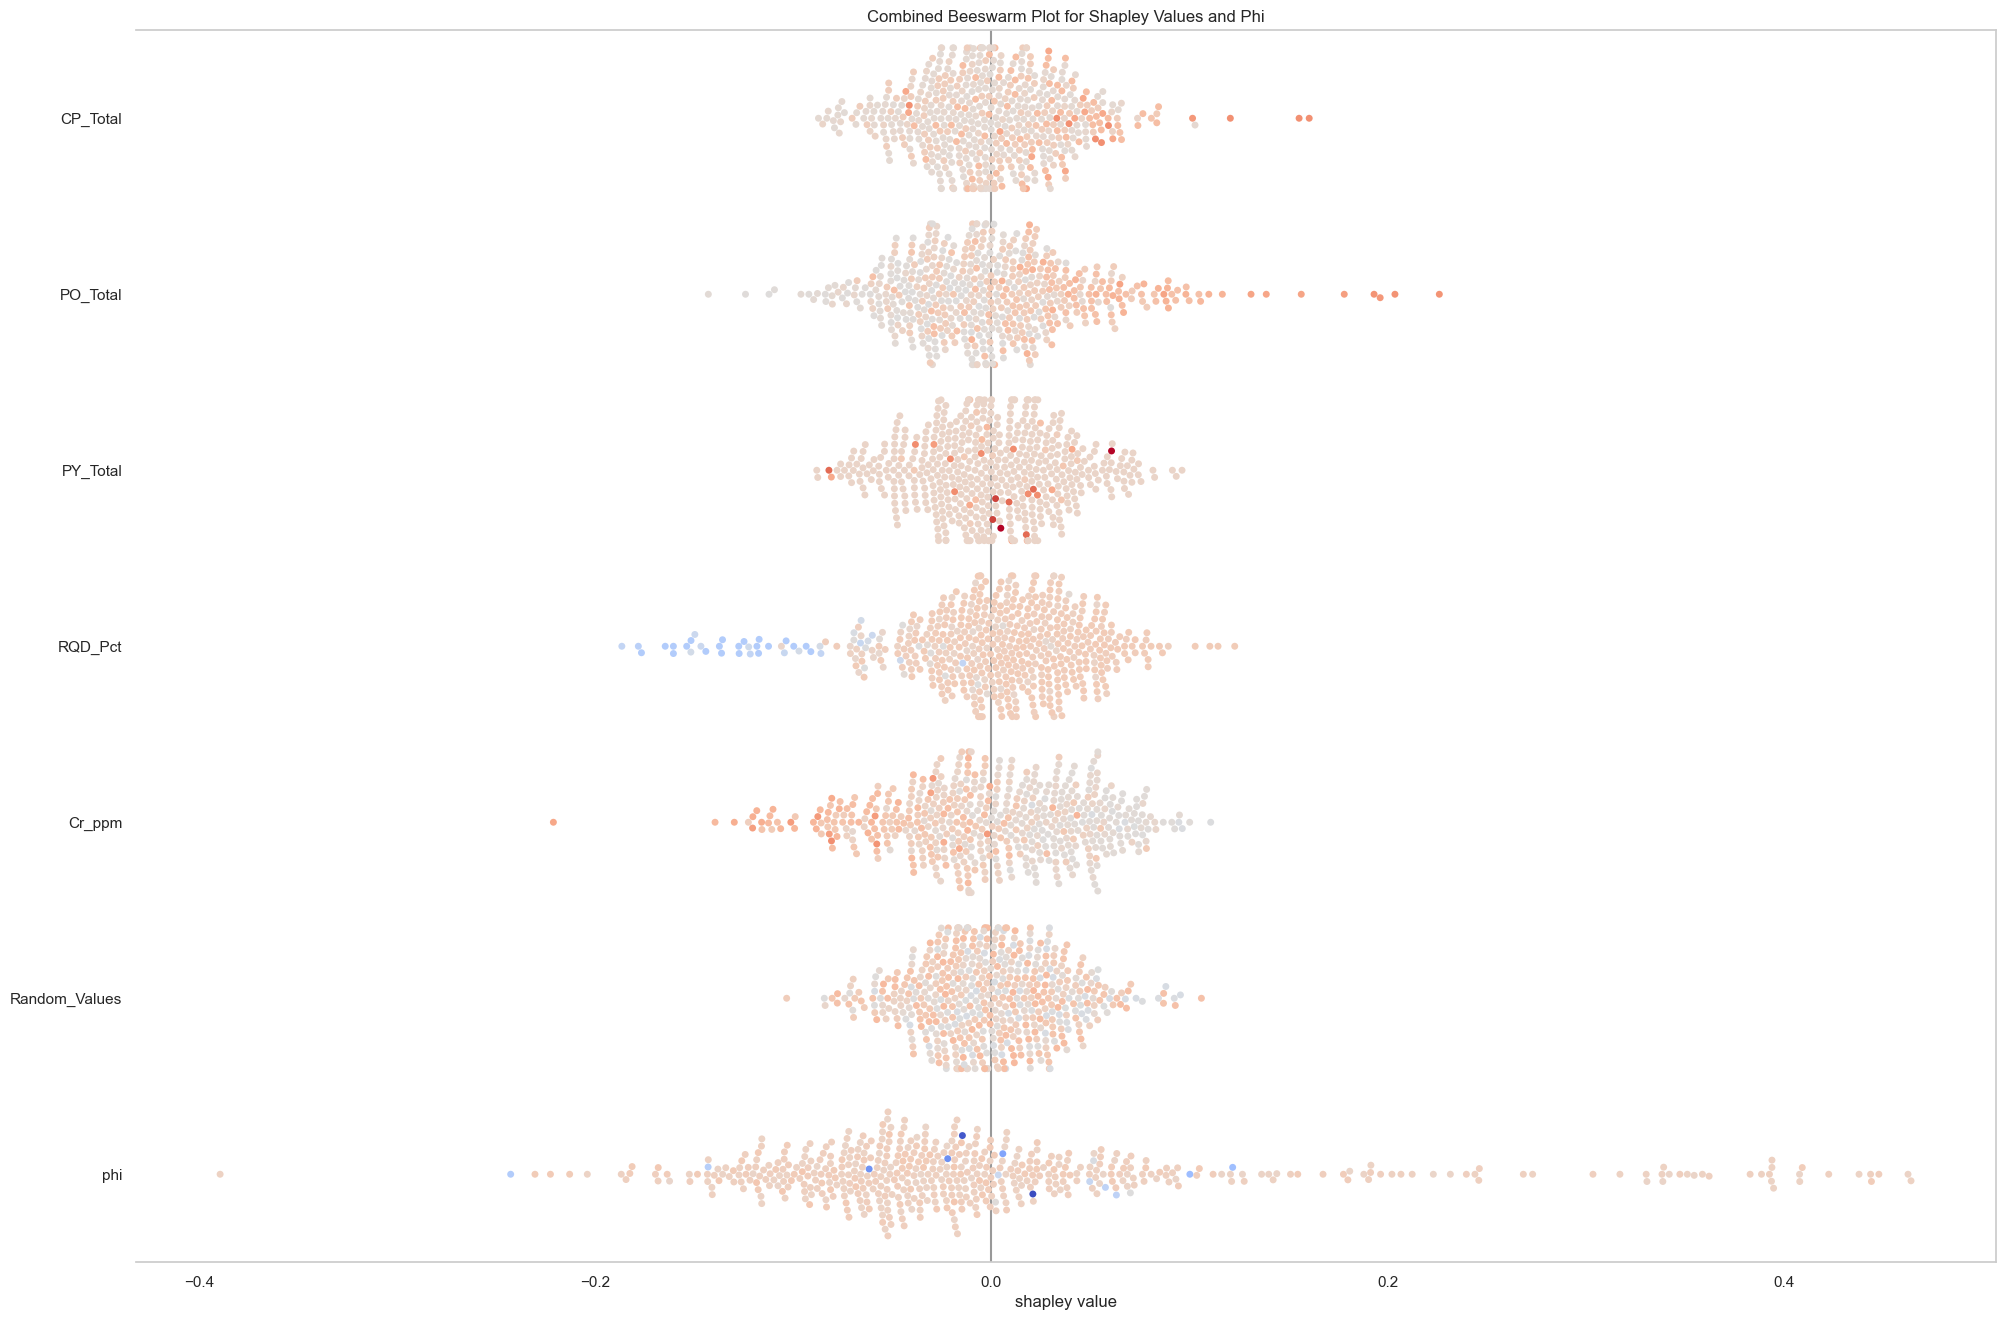

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_Random_Values,
# psi_phi, and X_test are your variables and DataFrame
# Replace these with your actual data

# Create DataFrames for the beeswarm plot
df_sv = pd.DataFrame()

# List of features
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'Random_Values']

# Populate the DataFrame with features, shapley values, and hue values
df_sv['feature'] = sum([[feature] * len(X_test) for feature in features], [])
df_sv['shapley value'] = np.concatenate([psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_Random_Values])
df_sv['hue'] = np.concatenate([
    (X_test[feature].values - X_test[feature].mean()) / X_test[feature].std() 
    for feature in features
])

# Add phi data to the existing DataFrame
df_sv_phi = pd.DataFrame()
df_sv_phi["feature"] = ["phi"] * len(X_test)
df_sv_phi["shapley value"] = psi_phi
df_sv_phi["hue"] = (mean_df['Mean'].values - mean_df['Mean'].mean()) / mean_df['Mean'].std()

df_sv = pd.concat([df_sv, df_sv_phi])

# Beeswarm plot
fig, ax = plt.subplots(figsize=(24, 16))  # Set the figure size (width, height)
ax.axvline(0, c="grey", alpha=0.8)
sns.swarmplot(
    x=df_sv['shapley value'],
    y=df_sv['feature'],
    hue=df_sv['hue'],
    palette='coolwarm',
    size=5,
    legend=False
)
ax.spines.left.set_visible(False)
ax.grid(axis='x')
ax.set_ylabel("")
plt.title('Combined Beeswarm Plot for Shapley Values and Phi')
plt.show()


In [ ]:
psi_CP_Total[0]

0.000111798756

In [ ]:
import plotly.graph_objects as go

# Assuming psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_Random_Values,
# psi_phi, and X_test are your variables and DataFrame
# Replace these with your actual data

# Create a combined DataFrame for the waterfall plot
df_waterfall_combined = pd.DataFrame()

# List of features
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'Random_Values']

# Populate the DataFrame with features, shapley values, and hue values for Shapley
df_waterfall_combined['feature'] = sum([[feature] * len(X_test) for feature in features], [])
df_waterfall_combined['shapley value'] = np.concatenate([psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_Random_Values])
df_waterfall_combined['source'] = ['Shapley'] * len(df_waterfall_combined)

# Populate the DataFrame with features, shapley values, and hue values for Phi
df_waterfall_phi = pd.DataFrame()
df_waterfall_phi["feature"] = ["phi"] * len(X_test)
df_waterfall_phi["shapley value"] = psi_phi
df_waterfall_phi["source"] = ['Phi'] * len(df_waterfall_phi)

df_waterfall_combined = pd.concat([df_waterfall_combined, df_waterfall_phi])

# Create a Waterfall plot for both Shapley and Phi values
fig_waterfall_combined = go.Figure()

for source, color in zip(['Shapley', 'Phi'], ['#008bfb', '#fb0655']):
    source_df = df_waterfall_combined[df_waterfall_combined['source'] == source]
    fig_waterfall_combined.add_trace(
        go.Waterfall(
            name=f"waterfall_{source}",
            orientation="h",
            y=source_df['feature'],
            x=source_df['shapley value'],
            base=0,  # Set the base value
            decreasing=dict(marker=dict(color=color)),
            increasing=dict(marker=dict(color=color))
        )
    )

fig_waterfall_combined.update_layout(
    title="Combined Waterfall Plot for Shapley and Phi Values",
    width=1000, height=500, font=dict(size=14),
)

# Save the figure


In [ ]:
import plotly.graph_objects as go

# Assuming psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_Random_Values,
# psi_phi, and X_test are your variables and DataFrame
# Replace these with your actual data

# Select a specific row (instance) from your dataset
instance_idx = 0  # Replace with the index of the instance you want to visualize
instance_row = X_test.iloc[instance_idx]

# Create a combined DataFrame for the waterfall plot
df_waterfall_combined = pd.DataFrame()

# List of features
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'Random_Values']

# Populate the DataFrame with features, shapley values, and hue values for Shapley
df_waterfall_combined['feature'] = features
df_waterfall_combined['shapley value'] = [
    psi_CP_Total[instance_idx],
    psi_PO_Total[instance_idx],
    psi_PY_Total[instance_idx],
    psi_RQD_Pct[instance_idx],
    psi_Cr_ppm[instance_idx],
    psi_Random_Values[instance_idx]
]
df_waterfall_combined['source'] = ['Shapley'] * len(df_waterfall_combined)

# Populate the DataFrame with features, shapley values, and hue values for Phi
df_waterfall_phi = pd.DataFrame()
df_waterfall_phi["feature"] = ["phi"]
df_waterfall_phi["shapley value"] = psi_phi[instance_idx]
df_waterfall_phi["source"] = ['Phi'] * len(df_waterfall_phi)

df_waterfall_combined = pd.concat([df_waterfall_combined, df_waterfall_phi])

# Create a Waterfall plot for both Shapley and Phi values
fig_waterfall_combined = go.Figure()

for source, color in zip(['Shapley', 'Phi'], ['#008bfb', '#fb0655']):
    source_df = df_waterfall_combined[df_waterfall_combined['source'] == source]
    fig_waterfall_combined.add_trace(
        go.Waterfall(
            name=f"waterfall_{source}",
            orientation="h",
            y=source_df['feature'],
            x=source_df['shapley value'],
            base=0,  # Set the base value
            decreasing=dict(marker=dict(color=color)),
            increasing=dict(marker=dict(color=color))
        )
    )

fig_waterfall_combined.update_layout(
    title="Combined Waterfall Plot for Shapley and Phi Values (Single Instance)",
    width=1000, height=500, font=dict(size=14),
)

# Save the figure
